# Analysis of the cold plasma dispersion relation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Utils.dispersionSolver import solveDispersionCold
from Utils.dispersionSolver import solveDispersionHybrid
from Utils.matrixAssembly import matrixAssembly
from Utils.createBasis import createBasis
from scipy import signal
from matplotlib.colors import LogNorm
from Utils_Dipole.evaluation import evaluation

In [3]:
# ... import simulation data
data1 = np.loadtxt('Results/02_ZeroIC/simulation_data_T=300_L=80.txt')

print('Data 1 imported!')

data2 = np.loadtxt('Results/02_ZeroIC/simulation_data_T=1500_L=327.7.txt')

print('Data 2 imported!')
# ...

Data 1 imported!
Data 2 imported!


# 1. Without growth and Dipole field

In [15]:
# ... get simulation parameters
pa = data1[0]

eps0  = pa[0]
mu0   = pa[1]
c     = pa[2]
qe    = pa[3]
me    = pa[4]
B0z   = pa[5]
wce   = pa[6]
wpe   = pa[7]
nuh   = pa[8]
nh    = pa[9]
wpar  = pa[10]
wperp = pa[11]
k     = pa[12]
ini   = np.int(pa[13])
amp   = pa[14]
eps   = pa[15]
Lz    = pa[16]
Nz    = np.int(pa[17])
T     = pa[18]
dt    = pa[19]
p     = np.int(pa[20])
Lv    = pa[21]
Nv    = np.int(pa[22])
Np    = np.int(pa[23])
xi    = pa[24]
bcs   = pa[25]
Ld    = pa[26]
bcs = 1
# ...

"\nplt.subplot(223)\nplt.contourf(Time,Omega,Sxx,100,cmap = 'jet')\n#plt.contourf(Time,Omega,Sxx,norm = LogNorm(),levels = lvls, cmap = 'jet')\n\nplt.plot(np.linspace(t[0],t[-1],100),np.ones(100)*omega_r*2,'k--')\nplt.xlabel('t |wce|')\nplt.xlabel('w / |wce|')\nplt.ylim((0,2))\nplt.colorbar()\nplt.title('time-frequency spectrogram')\n"

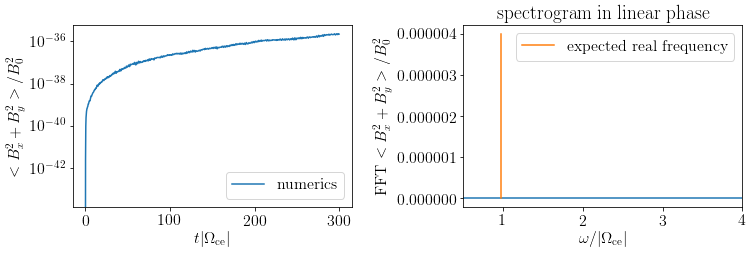

In [18]:
plt.rc('text',usetex = True)
plt.rc('font',family = 'serif')
plt.rcParams.update({'font.size': 16})
plt.rc('xtick',labelsize = 16)
plt.rc('ytick',labelsize = 16)

# ... additional parameters 
if bcs == 1:
    Nb = Nz
elif bcs == 2:
    Nb = Nz + p - 2
s = 6
ordering = 0
# ...



# ... discretization parameters
dz = Lz/Nz
zj = np.linspace(0,Lz,Nz+1)

Nt = np.int(T/dt)
tn = np.linspace(0,T,Nt+1)
# ...




# ... get simulation data
if ordering == 0:
    
    if bcs == 1:
    
        uj = data1[1:,0:s*Nb]
        yhj = data1[1:,s*Nb:8*Nb]

        ejx = uj[:,0::6]
        ejy = uj[:,1::6]
        bjx = uj[:,2::6]
        bjy = uj[:,3::6]
        ycjx = uj[:,4::6]
        ycjy = uj[:,5::6]
        yhjx = yhj[:,0::2]
        yhjy = yhj[:,1::2]
        
    elif bcs == 2:
        
        uj = data1[1:,0:s*Nb]
        yhj = data1[1:,s*Nb:8*Nb]

        ejx = np.c_[np.zeros(Nt+1),uj[:,0::6],np.zeros(Nt+1)]
        ejy = np.c_[np.zeros(Nt+1),uj[:,1::6],np.zeros(Nt+1)]
        bjx = np.c_[np.zeros(Nt+1),uj[:,2::6],np.zeros(Nt+1)]
        bjy = np.c_[np.zeros(Nt+1),uj[:,3::6],np.zeros(Nt+1)]
        ycjx = np.c_[np.zeros(Nt+1),uj[:,4::6],np.zeros(Nt+1)]
        ycjy = np.c_[np.zeros(Nt+1),uj[:,5::6],np.zeros(Nt+1)]
        yhjx = yhj[:,0::2]
        yhjy = yhj[:,1::2]
        
    
elif ordering == 1:
    
    if bcs == 1:
        
        ej = data1[1:,0:2*Nb]
        bj = data1[1:,2*Nb:4*Nb]
        ycj = data1[1:,4*Nb:6*Nb]
        yhj = data1[1:,6*Nb:8*Nb]

        ejx = ej[:,0::2]
        ejy = ej[:,1::2]
        bjx = bj[:,0::2]
        bjy = bj[:,1::2]
        ycjx = ycj[:,0::2]
        ycjy = ycj[:,1::2]
        yhjx = yhj[:,0::2]
        yhjy = yhj[:,1::2]   
    # ...



def damp(z):
    return 0*z

def B0(z):
    return 0*z


# ... create B-spline basis and compute mass matrix
basis,N,quad_points,weights = createBasis(Lz,Nz,p)
M = matrixAssembly(basis,p,Nz,weights,quad_points)[0]
# ...




# ... solve the dispersion relation for a fixed k to get ocillation frequency and growth rate 
omega = solveDispersionHybrid(k,+1,c,wce,wpe,wpar,wperp,nuh,0.5 + 0j,1e-6,100)[0]
omega_r = np.real(omega)
gamma = np.imag(omega)
# ...





# ... compute averaged quadratic magnetic field
mean_Bx2 = np.zeros(Nt+1)
mean_B2 = np.zeros(Nt+1)

for j in range(0,Nt+1):
    mean_Bx2[j] = 1/Lz*np.dot(bjx[j],np.dot(M,bjx[j]))
    mean_B2[j] = 1/Lz*(np.dot(bjx[j],np.dot(M,bjx[j])) + np.dot(bjy[j],np.dot(M,bjy[j])))
# ...

                       
                       
# ... compute fft for frequency analysis in linear phase 
Ntend = Nt
spec = np.fft.fft(mean_Bx2[0:Ntend+1])
spec = np.fft.fftshift(spec)
w = np.linspace(0,Ntend,Ntend+1) - Ntend/2
w = 2*np.pi*w/(Ntend*dt)
# ...



# ... compute time-frequency spectrum
f, t, Sxx = signal.spectrogram(mean_Bx2[0:],1/dt,nperseg = 1000,noverlap = None,nfft = None)
om = 2*np.pi*f
lvls = np.logspace(-15,-6,200)
Time,Omega = np.meshgrid(t,om)
# ...

                       
# ... plot results
f1 = plt.figure()
f1.set_figheight(8)
f1.set_figwidth(12)
plt.subplots_adjust(wspace = 0.4, hspace = 0.4)

plt.subplot(221)
plt.semilogy(tn,mean_B2,label = 'numerics')
t2 = np.linspace(0,T,100)
#plt.semilogy(t2,1.2e-36*np.exp(t2*test*2),label = 'expected growth rate')
plt.xlabel(r'$t |\Omega_\mathrm{ce}|$')
plt.ylabel(r'$<B_x^2+B_y^2>/B_0^2$')
plt.legend()

plt.subplot(222)
plt.plot(w,np.abs(spec))
plt.xlim((0.5,4))
plt.xlabel(r'$\omega/ |\Omega_\mathrm{ce}|$')
plt.ylabel(r'FFT $<B_x^2+B_y^2>/B_0^2$')
plt.plot(np.ones(20)*2*omega_r,np.linspace(0,4e-6,20),label = 'expected real frequency')
plt.legend()
plt.title('spectrogram in linear phase')

'''
plt.subplot(223)
plt.contourf(Time,Omega,Sxx,100,cmap = 'jet')
#plt.contourf(Time,Omega,Sxx,norm = LogNorm(),levels = lvls, cmap = 'jet')

plt.plot(np.linspace(t[0],t[-1],100),np.ones(100)*omega_r*2,'k--')
plt.xlabel('t |wce|')
plt.xlabel('w / |wce|')
plt.ylim((0,2))
plt.colorbar()
plt.title('time-frequency spectrogram')
'''
# ...

In [10]:
# ... compute 2D fft to investigate dispersion relation
w = np.linspace(0,Nt,Nt+1) - Nt/2
w = 2*np.pi/T*w

ks = np.linspace(0,Nz,Nz+1) - Nz/2
ks = 2*np.pi/Lz*ks

Bx = np.zeros((Nt+1,Nz+1))

for i in range(0,Nt+1):
    Bx[i] = evaluation(bjx[i],basis,zj,p,bcs)

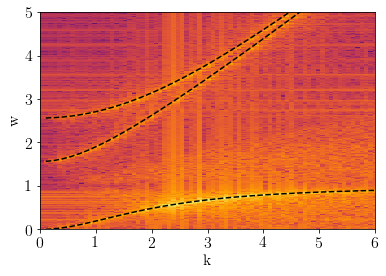

In [11]:
Bxkw = np.fft.fft2(Bx)
K,W = np.meshgrid(ks,w)
Bkw = np.fft.fftshift(Bxkw)
Bkw_plot = np.abs(Bkw)/np.abs(Bkw).max()
plt.pcolor(K,W,Bkw_plot,cmap = 'inferno',norm = LogNorm(vmin = Bkw_plot.min(),vmax = Bkw_plot.max()))
plt.xlim((0,6))
plt.ylim((0,5))
plt.xlabel('k')
plt.ylabel('w')

# ... Newton method for cold plasma dispersion relation for fixed k
k1 = np.linspace(0.1,6.0,40)

w1_1 = np.zeros(40)
w1_2 = np.zeros(40)
w1_3 = np.zeros(40)

w1_1[0] = 0.0001 
w1_2[0] = 1.5001 
w1_3[0] = 2.5001


for i in range(0,40):
    
    if i == 0:
        w1_1[i] = solveDispersionCold(k1[i],+1,c,wce,wpe,w1_1[i],1e-6,100)[0]
        w1_2[i] = solveDispersionCold(k1[i],-1,c,wce,wpe,w1_2[i],1e-6,100)[0]
        w1_3[i] = solveDispersionCold(k1[i],+1,c,wce,wpe,w1_3[i],1e-6,100)[0]
    
    else:
        w1_1[i] = solveDispersionCold(k1[i],+1,c,wce,wpe,w1_1[i-1],1e-6,100)[0]
        w1_2[i] = solveDispersionCold(k1[i],-1,c,wce,wpe,w1_2[i-1],1e-6,100)[0]
        w1_3[i] = solveDispersionCold(k1[i],+1,c,wce,wpe,w1_3[i-1],1e-6,100)[0]
    
# ...

plt.plot(k1,w1_1,'k--')
plt.plot(k1,w1_2,'k--')
plt.plot(k1,w1_3,'k--')

# 2. With growth and without Dipole Field

In [19]:
# ... get simulation parameters
pa = data2[0]

eps0  = pa[0]
mu0   = pa[1]
c     = pa[2]
qe    = pa[3]
me    = pa[4]
B0z   = pa[5]
wce   = pa[6]
wpe   = pa[7]
nuh   = pa[8]
nh    = pa[9]
wpar  = pa[10]
wperp = pa[11]
k     = pa[12]
ini   = np.int(pa[13])
amp   = pa[14]
eps   = pa[15]
Lz    = pa[16]
Nz    = np.int(pa[17])
T     = pa[18]
dt    = pa[19]
p     = np.int(pa[20])
Lv    = pa[21]
Nv    = np.int(pa[22])
Np    = np.int(pa[23])
xi    = pa[24]
bcs = 1
# ...

"\nplt.subplot(223)\nplt.contourf(Time,Omega,Sxx,100,cmap = 'jet')\n#plt.contourf(Time,Omega,Sxx,norm = LogNorm(),levels = lvls, cmap = 'jet')\n\nplt.plot(np.linspace(t[0],t[-1],100),np.ones(100)*omega_r*2,'k--')\nplt.xlabel('t |wce|')\nplt.xlabel('w / |wce|')\nplt.ylim((0,2))\nplt.colorbar()\nplt.title('time-frequency spectrogram')\n"

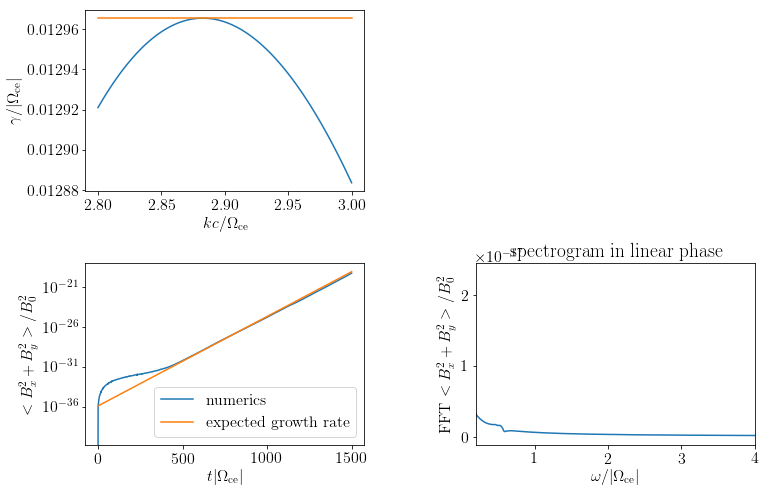

In [31]:
plt.rc('text',usetex = True)
plt.rc('font',family = 'serif')
plt.rcParams.update({'font.size': 16})
plt.rc('xtick',labelsize = 16)
plt.rc('ytick',labelsize = 16)

# ... additional parameters 
if bcs == 1:
    Nb = Nz
elif bcs == 2:
    Nb = Nz + p - 2
s = 6
ordering = 0
# ...



# ... discretization parameters
dz = Lz/Nz
zj = np.linspace(0,Lz,Nz+1)

Nt = np.int(T/dt)
tn = np.linspace(0,T,Nt+1)
# ...




# ... get simulation data
if ordering == 0:
    
    if bcs == 1:
    
        uj = data2[1:,0:s*Nb]
        yhj = data2[1:,s*Nb:8*Nb]

        ejx = uj[:,0::6]
        ejy = uj[:,1::6]
        bjx = uj[:,2::6]
        bjy = uj[:,3::6]
        ycjx = uj[:,4::6]
        ycjy = uj[:,5::6]
        yhjx = yhj[:,0::2]
        yhjy = yhj[:,1::2]
        
    elif bcs == 2:
        
        uj = data2[1:,0:s*Nb]
        yhj = data2[1:,s*Nb:8*Nb]

        ejx = np.c_[np.zeros(Nt+1),uj[:,0::6],np.zeros(Nt+1)]
        ejy = np.c_[np.zeros(Nt+1),uj[:,1::6],np.zeros(Nt+1)]
        bjx = np.c_[np.zeros(Nt+1),uj[:,2::6],np.zeros(Nt+1)]
        bjy = np.c_[np.zeros(Nt+1),uj[:,3::6],np.zeros(Nt+1)]
        ycjx = np.c_[np.zeros(Nt+1),uj[:,4::6],np.zeros(Nt+1)]
        ycjy = np.c_[np.zeros(Nt+1),uj[:,5::6],np.zeros(Nt+1)]
        yhjx = yhj[:,0::2]
        yhjy = yhj[:,1::2]
        
    
elif ordering == 1:
    
    if bcs == 1:
        
        ej = data2[1:,0:2*Nb]
        bj = data2[1:,2*Nb:4*Nb]
        ycj = data2[1:,4*Nb:6*Nb]
        yhj = data2[1:,6*Nb:8*Nb]

        ejx = ej[:,0::2]
        ejy = ej[:,1::2]
        bjx = bj[:,0::2]
        bjy = bj[:,1::2]
        ycjx = ycj[:,0::2]
        ycjy = ycj[:,1::2]
        yhjx = yhj[:,0::2]
        yhjy = yhj[:,1::2]   
    # ...



def damp(z):
    return 0*z

def B0(z):
    return 0*z


# ... create B-spline basis and compute mass matrix
basis,N,quad_points,weights = createBasis(Lz,Nz,p)
M = matrixAssembly(basis,p,Nz,weights,quad_points)[0]
# ...




# ... solve the dispersion relation for a fixed k to get ocillation frequency and growth rate 
omega = solveDispersionHybrid(k,+1,c,wce,wpe,wpar,wperp,nuh,0.5 + 0j,1e-6,100)[0]
omega_r = np.real(omega)
gamma = np.imag(omega)
# ...





# ... compute averaged quadratic magnetic field
mean_Bx2 = np.zeros(Nt+1)
mean_B2 = np.zeros(Nt+1)

for j in range(0,Nt+1):
    mean_Bx2[j] = 1/Lz*np.dot(bjx[j],np.dot(M,bjx[j]))
    mean_B2[j] = 1/Lz*(np.dot(bjx[j],np.dot(M,bjx[j])) + np.dot(bjy[j],np.dot(M,bjy[j])))
# ...

                       
                       
# ... compute fft for frequency analysis in linear phase 
Ntstart = 10000
Ntend = Nt
DELTA = Ntend - Ntstart
spec = np.fft.fft(mean_Bx2[Ntstart:Ntend+1])
spec = np.fft.fftshift(spec)
w = np.linspace(0,DELTA,DELTA+1) - DELTA/2
w = 2*np.pi*w/(DELTA*dt)
# ...



# ... compute time-frequency spectrum
f, t, Sxx = signal.spectrogram(mean_Bx2[0:],1/dt,nperseg = 1000,noverlap = None,nfft = None)
om = 2*np.pi*f
lvls = np.logspace(-15,-6,200)
Time,Omega = np.meshgrid(t,om)
# ...

                       
# ... plot results
f1 = plt.figure()
f1.set_figheight(8)
f1.set_figwidth(12)
plt.subplots_adjust(wspace = 0.4, hspace = 0.4)



ks = np.linspace(2.8,3.0,100)
ome = np.zeros(100,dtype = complex)

ome[0] = 0.0001 + 0j
 
for i in range(len(ks)):
    if i == 0:
        ome[i] = solveDispersionHybrid(ks[i],+1,c,wce,wpe,wpar,wperp,nuh,ome[i],1e-6,1000)[0]
    else:
        ome[i] = solveDispersionHybrid(ks[i],+1,c,wce,wpe,wpar,wperp,nuh,ome[i-1],1e-6,1000)[0]

        
plt.subplot(221)
plt.plot(ks,np.imag(ome))
gamma_max = 0.0129655
plt.plot(ks,np.ones(len(ks))*gamma_max)
plt.xlabel(r'$kc / \Omega_\mathrm{ce}$')
plt.ylabel(r'$\gamma / |\Omega_\mathrm{ce}|$')

plt.subplot(223)
plt.semilogy(tn,mean_B2,label = 'numerics')
t2 = np.linspace(0,T,100)
plt.semilogy(t2,1.2e-36*np.exp(t2*gamma_max*2),label = 'expected growth rate')
plt.xlabel(r'$t |\Omega_\mathrm{ce}|$')
plt.ylabel(r'$<B_x^2+B_y^2>/B_0^2$')
plt.legend()

plt.subplot(224)
plt.plot(w,np.abs(spec))
plt.xlim((0.2,4))
plt.xlabel(r'$\omega/ |\Omega_\mathrm{ce}|$')
plt.ylabel(r'FFT $<B_x^2+B_y^2>/B_0^2$')
#plt.plot(np.ones(20)*2*omega_r,np.linspace(0,4e-6,20),label = 'expected real frequency')
#plt.legend()
plt.title('spectrogram in linear phase')

'''
plt.subplot(223)
plt.contourf(Time,Omega,Sxx,100,cmap = 'jet')
#plt.contourf(Time,Omega,Sxx,norm = LogNorm(),levels = lvls, cmap = 'jet')

plt.plot(np.linspace(t[0],t[-1],100),np.ones(100)*omega_r*2,'k--')
plt.xlabel('t |wce|')
plt.xlabel('w / |wce|')
plt.ylim((0,2))
plt.colorbar()
plt.title('time-frequency spectrogram')
'''
# ...

# 3. Without growth and with Dipole Field ($\xi=0$)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from Utils.dispersionSolver import solveDispersionCold
from Utils.dispersionSolver import solveDispersionHybrid
from Utils_Dipole.matrixAssembly import matrixAssembly
from Utils_Dipole.createBasis import createBasis
from scipy import signal
from matplotlib.colors import LogNorm
from Utils_Dipole.evaluation import evaluation

In [14]:
# ... import simulation data
data1 = np.loadtxt('Results/03_DipoleField/simulation_data_T=300_L=80_xi=0.txt')

print('Data 1 imported!')

data2 = np.loadtxt('Results/03_DipoleField/simulation_data_T=1500_L=327.7_xi=0_p.c.txt')

print('Data 2 imported!')
# ...

Data 1 imported!
Data 2 imported!


In [7]:
# ... get simulation parameters
pa = data1[0]

eps0  = pa[0]
mu0   = pa[1]
c     = pa[2]
qe    = pa[3]
me    = pa[4]
B0z   = pa[5]
wce   = pa[6]
wpe   = pa[7]
nuh   = pa[8]
nh    = pa[9]
wpar  = pa[10]
wperp = pa[11]
k     = pa[12]
ini   = np.int(pa[13])
amp   = pa[14]
eps   = pa[15]
Lz    = pa[16]
Nz    = np.int(pa[17])
T     = pa[18]
dt    = pa[19]
p     = np.int(pa[20])
Lv    = pa[21]
Nv    = np.int(pa[22])
Np    = np.int(pa[23])
xi    = pa[24]
bcs   = pa[25]
Ld    = pa[26]
bcs = 2
# ...

"\nplt.subplot(223)\nplt.contourf(Time,Omega,Sxx,100,cmap = 'jet')\n#plt.contourf(Time,Omega,Sxx,norm = LogNorm(),levels = lvls, cmap = 'jet')\n\nplt.plot(np.linspace(t[0],t[-1],100),np.ones(100)*omega_r*2,'k--')\nplt.xlabel('t |wce|')\nplt.xlabel('w / |wce|')\nplt.ylim((0,2))\nplt.colorbar()\nplt.title('time-frequency spectrogram')\n"

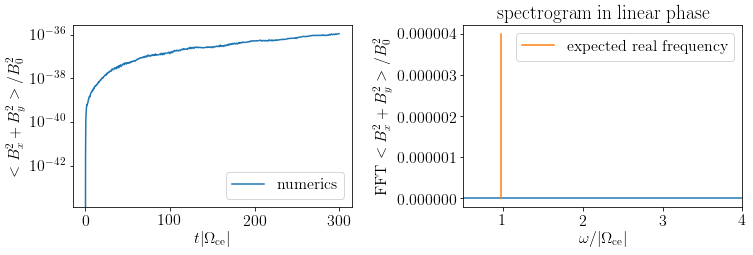

In [8]:
plt.rc('text',usetex = True)
plt.rc('font',family = 'serif')
plt.rcParams.update({'font.size': 16})
plt.rc('xtick',labelsize = 16)
plt.rc('ytick',labelsize = 16)

# ... additional parameters 
if bcs == 1:
    Nb = Nz
elif bcs == 2:
    Nb = Nz + p - 2
s = 6
ordering = 0
# ...



# ... discretization parameters
dz = Lz/Nz
zj = np.linspace(0,Lz,Nz+1)

Nt = np.int(T/dt)
tn = np.linspace(0,T,Nt+1)
# ...




# ... get simulation data
if ordering == 0:
    
    if bcs == 1:
    
        uj = data1[1:,0:s*Nb]
        yhj = data1[1:,s*Nb:8*Nb]

        ejx = uj[:,0::6]
        ejy = uj[:,1::6]
        bjx = uj[:,2::6]
        bjy = uj[:,3::6]
        ycjx = uj[:,4::6]
        ycjy = uj[:,5::6]
        yhjx = yhj[:,0::2]
        yhjy = yhj[:,1::2]
        
    elif bcs == 2:
        
        uj = data1[1:,0:s*Nb]
        yhj = data1[1:,s*Nb:8*Nb]

        ejx = np.c_[np.zeros(Nt+1),uj[:,0::6],np.zeros(Nt+1)]
        ejy = np.c_[np.zeros(Nt+1),uj[:,1::6],np.zeros(Nt+1)]
        bjx = np.c_[np.zeros(Nt+1),uj[:,2::6],np.zeros(Nt+1)]
        bjy = np.c_[np.zeros(Nt+1),uj[:,3::6],np.zeros(Nt+1)]
        ycjx = np.c_[np.zeros(Nt+1),uj[:,4::6],np.zeros(Nt+1)]
        ycjy = np.c_[np.zeros(Nt+1),uj[:,5::6],np.zeros(Nt+1)]
        yhjx = yhj[:,0::2]
        yhjy = yhj[:,1::2]
        
    
elif ordering == 1:
    
    if bcs == 1:
        
        ej = data1[1:,0:2*Nb]
        bj = data1[1:,2*Nb:4*Nb]
        ycj = data1[1:,4*Nb:6*Nb]
        yhj = data1[1:,6*Nb:8*Nb]

        ejx = ej[:,0::2]
        ejy = ej[:,1::2]
        bjx = bj[:,0::2]
        bjy = bj[:,1::2]
        ycjx = ycj[:,0::2]
        ycjy = ycj[:,1::2]
        yhjx = yhj[:,0::2]
        yhjy = yhj[:,1::2]   
    # ...



def damp(z):
    return 0*z

def B0(z):
    return 0*z


# ... create B-spline basis and compute mass matrix
basis,N,quad_points,weights = createBasis(Lz,Nz,p,bcs)
M = matrixAssembly(basis,p,Nz,weights,quad_points,B0,bcs,damp,damp)[0]
# ...




# ... solve the dispersion relation for a fixed k to get ocillation frequency and growth rate 
omega = solveDispersionHybrid(k,+1,c,wce,wpe,wpar,wperp,nuh,0.5 + 0j,1e-6,100)[0]
omega_r = np.real(omega)
gamma = np.imag(omega)
# ...





# ... compute averaged quadratic magnetic field
mean_Bx2 = np.zeros(Nt+1)
mean_B2 = np.zeros(Nt+1)

for j in range(0,Nt+1):
    mean_Bx2[j] = 1/Lz*np.dot(bjx[j],np.dot(M,bjx[j]))
    mean_B2[j] = 1/Lz*(np.dot(bjx[j],np.dot(M,bjx[j])) + np.dot(bjy[j],np.dot(M,bjy[j])))
# ...

                       
                       
# ... compute fft for frequency analysis in linear phase 
Ntend = Nt
spec = np.fft.fft(mean_Bx2[0:Ntend+1])
spec = np.fft.fftshift(spec)
w = np.linspace(0,Ntend,Ntend+1) - Ntend/2
w = 2*np.pi*w/(Ntend*dt)
# ...



# ... compute time-frequency spectrum
f, t, Sxx = signal.spectrogram(mean_Bx2[0:],1/dt,nperseg = 1000,noverlap = None,nfft = None)
om = 2*np.pi*f
lvls = np.logspace(-15,-6,200)
Time,Omega = np.meshgrid(t,om)
# ...

                       
# ... plot results
f1 = plt.figure()
f1.set_figheight(8)
f1.set_figwidth(12)
plt.subplots_adjust(wspace = 0.4, hspace = 0.4)

plt.subplot(221)
plt.semilogy(tn,mean_B2,label = 'numerics')
t2 = np.linspace(0,T,100)
#plt.semilogy(t2,1.2e-36*np.exp(t2*test*2),label = 'expected growth rate')
plt.xlabel(r'$t |\Omega_\mathrm{ce}|$')
plt.ylabel(r'$<B_x^2+B_y^2>/B_0^2$')
plt.legend()

plt.subplot(222)
plt.plot(w,np.abs(spec))
plt.xlim((0.5,4))
plt.xlabel(r'$\omega/ |\Omega_\mathrm{ce}|$')
plt.ylabel(r'FFT $<B_x^2+B_y^2>/B_0^2$')
plt.plot(np.ones(20)*2*omega_r,np.linspace(0,4e-6,20),label = 'expected real frequency')
plt.legend()
plt.title('spectrogram in linear phase')

'''
plt.subplot(223)
plt.contourf(Time,Omega,Sxx,100,cmap = 'jet')
#plt.contourf(Time,Omega,Sxx,norm = LogNorm(),levels = lvls, cmap = 'jet')

plt.plot(np.linspace(t[0],t[-1],100),np.ones(100)*omega_r*2,'k--')
plt.xlabel('t |wce|')
plt.xlabel('w / |wce|')
plt.ylim((0,2))
plt.colorbar()
plt.title('time-frequency spectrogram')
'''
# ...

In [24]:
# ... compute 2D fft to investigate dispersion relation
w = np.linspace(0,Nt,Nt+1) - Nt/2
w = 2*np.pi/T*w

ks = np.linspace(0,Nz,Nz+1) - Nz/2
ks = 2*np.pi/Lz*ks

Bx = np.zeros((Nt+1,Nz+1))

for i in range(0,Nt+1):
    Bx[i] = evaluation(bjx[i],basis,zj,p,bcs)

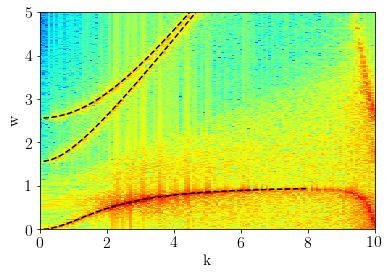

In [26]:
Bxkw = np.fft.fft2(Bx)
K,W = np.meshgrid(ks,w)
Bkw = np.fft.fftshift(Bxkw)
Bkw_plot = np.abs(Bkw)/np.abs(Bkw).max()
plt.pcolor(K,W,Bkw_plot,cmap = 'jet',norm = LogNorm(vmin = Bkw_plot.min(),vmax = Bkw_plot.max()))
plt.xlim((0,10))
plt.ylim((0,5))
plt.xlabel('k')
plt.ylabel('w')

# ... Newton method for cold plasma dispersion relation for fixed k
k1 = np.linspace(0.1,8.0,40)

w1_1 = np.zeros(40)
w1_2 = np.zeros(40)
w1_3 = np.zeros(40)

w1_1[0] = 0.0001 
w1_2[0] = 1.5001 
w1_3[0] = 2.5001


for i in range(0,40):
    
    if i == 0:
        w1_1[i] = solveDispersionCold(k1[i],+1,c,wce,wpe,w1_1[i],1e-6,100)[0]
        w1_2[i] = solveDispersionCold(k1[i],-1,c,wce,wpe,w1_2[i],1e-6,100)[0]
        w1_3[i] = solveDispersionCold(k1[i],+1,c,wce,wpe,w1_3[i],1e-6,100)[0]
    
    else:
        w1_1[i] = solveDispersionCold(k1[i],+1,c,wce,wpe,w1_1[i-1],1e-6,100)[0]
        w1_2[i] = solveDispersionCold(k1[i],-1,c,wce,wpe,w1_2[i-1],1e-6,100)[0]
        w1_3[i] = solveDispersionCold(k1[i],+1,c,wce,wpe,w1_3[i-1],1e-6,100)[0]
    
# ...

plt.plot(k1,w1_1,'k--')
plt.plot(k1,w1_2,'k--')
plt.plot(k1,w1_3,'k--')

# 4. With growth and with Dipole Field ($\xi=0$)

In [21]:
# ... get simulation parameters
pa = data2[0]

eps0  = pa[0]
mu0   = pa[1]
c     = pa[2]
qe    = pa[3]
me    = pa[4]
B0z   = pa[5]
wce   = pa[6]
wpe   = pa[7]
nuh   = pa[8]
nh    = pa[9]
wpar  = pa[10]
wperp = pa[11]
k     = pa[12]
ini   = np.int(pa[13])
amp   = pa[14]
eps   = pa[15]
Lz    = pa[16]
Nz    = np.int(pa[17])
T     = pa[18]
dt    = pa[19]
p     = np.int(pa[20])
Lv    = pa[21]
Nv    = np.int(pa[22])
Np    = np.int(pa[23])
xi    = pa[24]
bcs   = pa[25]
Ld    = pa[26]
bcs = 2
# ...

"\nplt.subplot(223)\nplt.contourf(Time,Omega,Sxx,100,cmap = 'jet')\n#plt.contourf(Time,Omega,Sxx,norm = LogNorm(),levels = lvls, cmap = 'jet')\n\nplt.plot(np.linspace(t[0],t[-1],100),np.ones(100)*omega_r*2,'k--')\nplt.xlabel('t |wce|')\nplt.xlabel('w / |wce|')\nplt.ylim((0,2))\nplt.colorbar()\nplt.title('time-frequency spectrogram')\n"

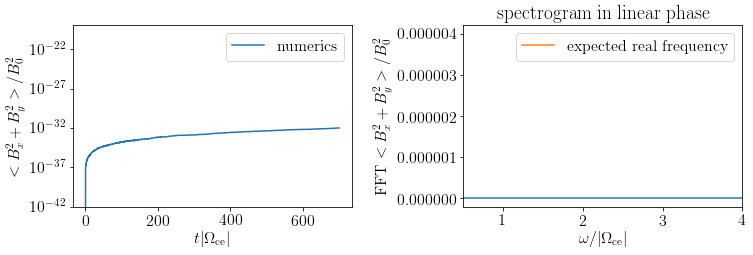

In [22]:
plt.rc('text',usetex = True)
plt.rc('font',family = 'serif')
plt.rcParams.update({'font.size': 16})
plt.rc('xtick',labelsize = 16)
plt.rc('ytick',labelsize = 16)

# ... additional parameters 
if bcs == 1:
    Nb = Nz
elif bcs == 2:
    Nb = Nz + p - 2
s = 6
ordering = 0
# ...



# ... discretization parameters
dz = Lz/Nz
zj = np.linspace(0,Lz,Nz+1)

Nt = np.int(T/dt)
tn = np.linspace(0,T,Nt+1)
# ...




# ... get simulation data
if ordering == 0:
    
    if bcs == 1:
    
        uj = data2[1:,0:s*Nb]
        yhj = data2[1:,s*Nb:8*Nb]

        ejx = uj[:,0::6]
        ejy = uj[:,1::6]
        bjx = uj[:,2::6]
        bjy = uj[:,3::6]
        ycjx = uj[:,4::6]
        ycjy = uj[:,5::6]
        yhjx = yhj[:,0::2]
        yhjy = yhj[:,1::2]
        
    elif bcs == 2:
        
        uj = data2[1:,0:s*Nb]
        yhj = data2[1:,s*Nb:8*Nb]

        ejx = np.c_[np.zeros(Nt+1),uj[:,0::6],np.zeros(Nt+1)]
        ejy = np.c_[np.zeros(Nt+1),uj[:,1::6],np.zeros(Nt+1)]
        bjx = np.c_[np.zeros(Nt+1),uj[:,2::6],np.zeros(Nt+1)]
        bjy = np.c_[np.zeros(Nt+1),uj[:,3::6],np.zeros(Nt+1)]
        ycjx = np.c_[np.zeros(Nt+1),uj[:,4::6],np.zeros(Nt+1)]
        ycjy = np.c_[np.zeros(Nt+1),uj[:,5::6],np.zeros(Nt+1)]
        yhjx = yhj[:,0::2]
        yhjy = yhj[:,1::2]
        
    
elif ordering == 1:
    
    if bcs == 1:
        
        ej = data2[1:,0:2*Nb]
        bj = data2[1:,2*Nb:4*Nb]
        ycj = data2[1:,4*Nb:6*Nb]
        yhj = data2[1:,6*Nb:8*Nb]

        ejx = ej[:,0::2]
        ejy = ej[:,1::2]
        bjx = bj[:,0::2]
        bjy = bj[:,1::2]
        ycjx = ycj[:,0::2]
        ycjy = ycj[:,1::2]
        yhjx = yhj[:,0::2]
        yhjy = yhj[:,1::2]   
    # ...



def damp(z):
    return 0*z

def B0(z):
    return 0*z


# ... create B-spline basis and compute mass matrix
basis,N,quad_points,weights = createBasis(Lz,Nz,p,bcs)
M = matrixAssembly(basis,p,Nz,weights,quad_points,B0,bcs,damp,damp)[0]
# ...




# ... solve the dispersion relation for a fixed k to get ocillation frequency and growth rate 
omega = solveDispersionHybrid(k,+1,c,wce,wpe,wpar,wperp,nuh,0.5 + 0j,1e-6,100)[0]
omega_r = np.real(omega)
gamma = np.imag(omega)
# ...





# ... compute averaged quadratic magnetic field
mean_Bx2 = np.zeros(Nt+1)
mean_B2 = np.zeros(Nt+1)

for j in range(0,Nt+1):
    mean_Bx2[j] = 1/Lz*np.dot(bjx[j],np.dot(M,bjx[j]))
    mean_B2[j] = 1/Lz*(np.dot(bjx[j],np.dot(M,bjx[j])) + np.dot(bjy[j],np.dot(M,bjy[j])))
# ...

                       
                       
# ... compute fft for frequency analysis in linear phase 
Ntend = Nt
spec = np.fft.fft(mean_Bx2[0:Ntend+1])
spec = np.fft.fftshift(spec)
w = np.linspace(0,Ntend,Ntend+1) - Ntend/2
w = 2*np.pi*w/(Ntend*dt)
# ...



# ... compute time-frequency spectrum
f, t, Sxx = signal.spectrogram(mean_Bx2[0:],1/dt,nperseg = 1000,noverlap = None,nfft = None)
om = 2*np.pi*f
lvls = np.logspace(-15,-6,200)
Time,Omega = np.meshgrid(t,om)
# ...

                       
# ... plot results
f1 = plt.figure()
f1.set_figheight(8)
f1.set_figwidth(12)
plt.subplots_adjust(wspace = 0.4, hspace = 0.4)

plt.subplot(221)
plt.semilogy(tn,mean_B2,label = 'numerics')
plt.ylim((1e-42,1e-19))
t2 = np.linspace(0,T,100)
#plt.semilogy(t2,1.2e-36*np.exp(t2*test*2),label = 'expected growth rate')
plt.xlabel(r'$t |\Omega_\mathrm{ce}|$')
plt.ylabel(r'$<B_x^2+B_y^2>/B_0^2$')
plt.legend()

plt.subplot(222)
plt.plot(w,np.abs(spec))
plt.xlim((0.5,4))
plt.xlabel(r'$\omega/ |\Omega_\mathrm{ce}|$')
plt.ylabel(r'FFT $<B_x^2+B_y^2>/B_0^2$')
plt.plot(np.ones(20)*2*omega_r,np.linspace(0,4e-6,20),label = 'expected real frequency')
plt.legend()
plt.title('spectrogram in linear phase')

'''
plt.subplot(223)
plt.contourf(Time,Omega,Sxx,100,cmap = 'jet')
#plt.contourf(Time,Omega,Sxx,norm = LogNorm(),levels = lvls, cmap = 'jet')

plt.plot(np.linspace(t[0],t[-1],100),np.ones(100)*omega_r*2,'k--')
plt.xlabel('t |wce|')
plt.xlabel('w / |wce|')
plt.ylim((0,2))
plt.colorbar()
plt.title('time-frequency spectrogram')
'''
# ...

In [23]:
M[0].size

303